# CNN Classifier

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

import os

PROJECT_ROOT = ".." 
DIRS = {
    'data':    os.path.join(PROJECT_ROOT, 'outputs', 'data'),
    'models':  os.path.join(PROJECT_ROOT, 'outputs', 'models'),
    'figures': os.path.join(PROJECT_ROOT, 'outputs', 'figures'),
    'results': os.path.join(PROJECT_ROOT, 'outputs', 'results')
}

In [10]:
class CNN(nn.Module):
  def __init__(self, num_classes=20, input_shape=(1, 112, 92)):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
    )
    self.block3 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=2, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.BatchNorm2d(32)
    )

    dummy = torch.zeros(1, *input_shape)
    out = self._forward_features(dummy)
    flattened_dim = out.numel()

    self.fc = nn.Sequential(
        nn.Linear(flattened_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, num_classes)
    )

  def _forward_features(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    return x

  def forward(self, x):
    x = self._forward_features(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

model = CNN()
model

CNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=4576, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False

In [11]:
X_train = np.load(f"{DIRS['data']}/X_train.npy")
y_train = np.load(f"{DIRS['data']}/y_train.npy")
X_val = np.load(f"{DIRS['data']}/X_val.npy")
y_val = np.load(f"{DIRS['data']}/y_val.npy")
X_test = np.load(f"{DIRS['data']}/X_test.npy")
y_test = np.load(f"{DIRS['data']}/y_test.npy")

epochs = 200
batch_size = 128
learning_rate = 5e-4

X_train_tensor = torch.from_numpy(X_train).float().reshape(-1, 1, 112, 92)
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float().reshape(-1, 1, 112, 92)
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.from_numpy(X_test).float().reshape(-1, 1, 112, 92)
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:

def train_epoch(model, loader, criterion, optimizer, device):
  model.train()
  running_loss = 0
  correct = 0
  total = 0

  for X, y in loader:
    X, y = X.to(device), y.to(device)
    
    optimizer.zero_grad()

    out = model(X)
    loss = criterion(out, y)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * X.size(0)

    _, preds = torch.max(out, 1)
    correct += (preds == y).sum().item()
    total += y.size(0)

  epoch_loss = running_loss / total
  epoch_acc = correct / total
  return epoch_loss, epoch_acc

def eval_epoch(model, loader, criterion, device):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for X, y in loader:
      X, y = X.to(device), y.to(device)
      
      out = model(X)
      loss = criterion(out, y)

      running_loss += loss.item() * X.size(0)

      _, preds = torch.max(out, 1)
      correct += (preds == y).sum().item()
      total += y.size(0)

  epoch_loss = running_loss / total
  epoch_acc = correct / total
  return epoch_loss, epoch_acc

In [13]:
from tqdm import tqdm
from torch import optim


def train(model, train_loader, val_loader, epochs, device, learning_rate=5e-4):
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.to(device)

  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []
  
  best_val_acc = 0.0

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc, = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      torch.save(model.state_dict(), f"{DIRS['models']}/cnn_best.pth")
      print(f"  → Best model saved! (val_acc: {val_acc:.4f})")
  
  return train_losses, val_losses, train_accs, val_accs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

model = CNN()
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, epochs=30, device=device, learning_rate=learning_rate)

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


  3%|▎         | 1/30 [00:00<00:11,  2.51it/s]

Epoch 1/30
- Train loss: 2.9004, acc: 0.1449
- Val loss: 2.9453, acc: 0.1652
  → Best model saved! (val_acc: 0.1652)
Epoch 2/30
- Train loss: 2.4532, acc: 0.3710
- Val loss: 2.8103, acc: 0.4870
  → Best model saved! (val_acc: 0.4870)
Epoch 3/30
- Train loss: 2.0029, acc: 0.5188
- Val loss: 2.5833, acc: 0.6696


 17%|█▋        | 5/30 [00:00<00:03,  7.46it/s]

  → Best model saved! (val_acc: 0.6696)
Epoch 4/30
- Train loss: 1.5980, acc: 0.5855
- Val loss: 2.2877, acc: 0.7739
  → Best model saved! (val_acc: 0.7739)
Epoch 5/30
- Train loss: 1.2083, acc: 0.7043
- Val loss: 1.9324, acc: 0.8609
  → Best model saved! (val_acc: 0.8609)


 27%|██▋       | 8/30 [00:01<00:02,  9.01it/s]

Epoch 6/30
- Train loss: 1.0154, acc: 0.7246
- Val loss: 1.5417, acc: 0.8870
  → Best model saved! (val_acc: 0.8870)
Epoch 7/30
- Train loss: 0.8366, acc: 0.7797
- Val loss: 1.1528, acc: 0.8957
  → Best model saved! (val_acc: 0.8957)
Epoch 8/30
- Train loss: 0.5725, acc: 0.8783
- Val loss: 0.7983, acc: 0.8870


 33%|███▎      | 10/30 [00:01<00:02,  9.50it/s]

Epoch 9/30
- Train loss: 0.4828, acc: 0.8754
- Val loss: 0.5405, acc: 0.9391
  → Best model saved! (val_acc: 0.9391)
Epoch 10/30
- Train loss: 0.3520, acc: 0.9130
- Val loss: 0.3704, acc: 0.9739
  → Best model saved! (val_acc: 0.9739)
Epoch 11/30
- Train loss: 0.2749, acc: 0.9449
- Val loss: 0.2601, acc: 0.9826


 40%|████      | 12/30 [00:01<00:01,  9.99it/s]

  → Best model saved! (val_acc: 0.9826)
Epoch 12/30
- Train loss: 0.2552, acc: 0.9391
- Val loss: 0.1680, acc: 0.9826
Epoch 13/30
- Train loss: 0.1963, acc: 0.9594
- Val loss: 0.0971, acc: 0.9913
  → Best model saved! (val_acc: 0.9913)


 53%|█████▎    | 16/30 [00:01<00:01, 10.86it/s]

Epoch 14/30
- Train loss: 0.1918, acc: 0.9507
- Val loss: 0.0621, acc: 0.9913
Epoch 15/30
- Train loss: 0.1934, acc: 0.9391
- Val loss: 0.0491, acc: 0.9913
Epoch 16/30
- Train loss: 0.1223, acc: 0.9768
- Val loss: 0.0399, acc: 0.9913


 60%|██████    | 18/30 [00:01<00:01, 10.80it/s]

Epoch 17/30
- Train loss: 0.1301, acc: 0.9739
- Val loss: 0.0302, acc: 0.9913
Epoch 18/30
- Train loss: 0.1096, acc: 0.9623
- Val loss: 0.0212, acc: 1.0000
  → Best model saved! (val_acc: 1.0000)
Epoch 19/30
- Train loss: 0.0975, acc: 0.9768
- Val loss: 0.0157, acc: 1.0000


 73%|███████▎  | 22/30 [00:02<00:00, 11.41it/s]

Epoch 20/30
- Train loss: 0.0797, acc: 0.9826
- Val loss: 0.0137, acc: 1.0000
Epoch 21/30
- Train loss: 0.0648, acc: 0.9913
- Val loss: 0.0123, acc: 1.0000
Epoch 22/30
- Train loss: 0.0672, acc: 0.9797
- Val loss: 0.0100, acc: 1.0000


 80%|████████  | 24/30 [00:02<00:00, 11.58it/s]

Epoch 23/30
- Train loss: 0.0518, acc: 0.9884
- Val loss: 0.0083, acc: 1.0000
Epoch 24/30
- Train loss: 0.0586, acc: 0.9942
- Val loss: 0.0077, acc: 1.0000
Epoch 25/30
- Train loss: 0.0557, acc: 0.9884
- Val loss: 0.0074, acc: 1.0000


 93%|█████████▎| 28/30 [00:02<00:00, 11.82it/s]

Epoch 26/30
- Train loss: 0.0460, acc: 0.9884
- Val loss: 0.0070, acc: 1.0000
Epoch 27/30
- Train loss: 0.0528, acc: 0.9913
- Val loss: 0.0064, acc: 1.0000
Epoch 28/30
- Train loss: 0.0431, acc: 0.9913
- Val loss: 0.0058, acc: 1.0000


100%|██████████| 30/30 [00:02<00:00, 10.09it/s]

Epoch 29/30
- Train loss: 0.0704, acc: 0.9797
- Val loss: 0.0046, acc: 1.0000
Epoch 30/30
- Train loss: 0.0355, acc: 0.9913
- Val loss: 0.0046, acc: 1.0000


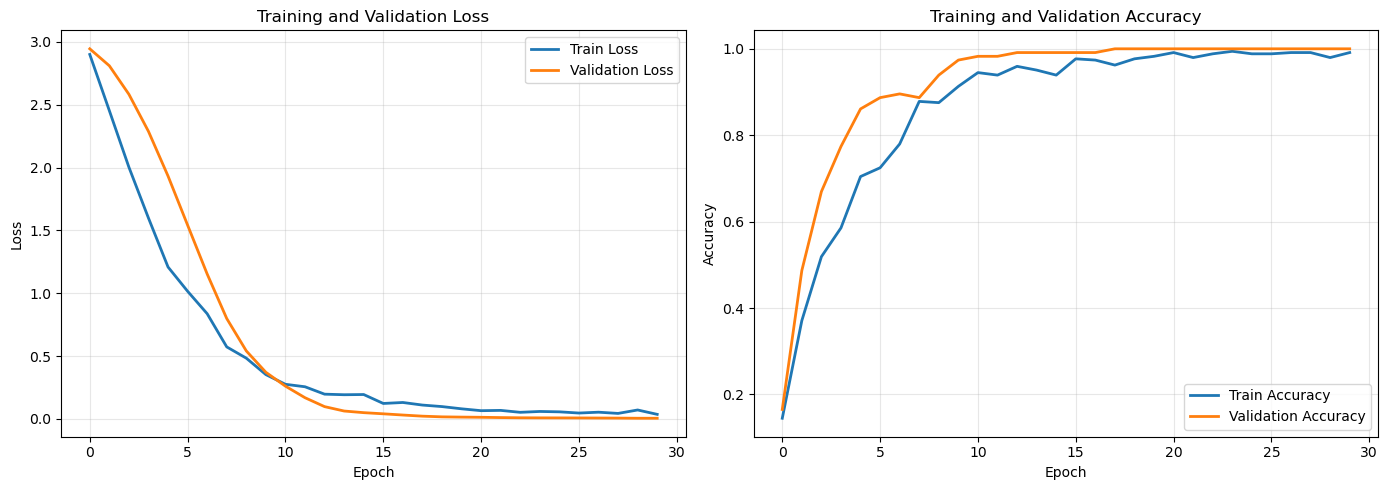

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/05_cnn_training_history.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def evaluate_model(model, test_loader, device):
    """Evaluate model on test set with device-agnostic code"""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

In [15]:
# Evaluate on test set
test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader, device)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.13%


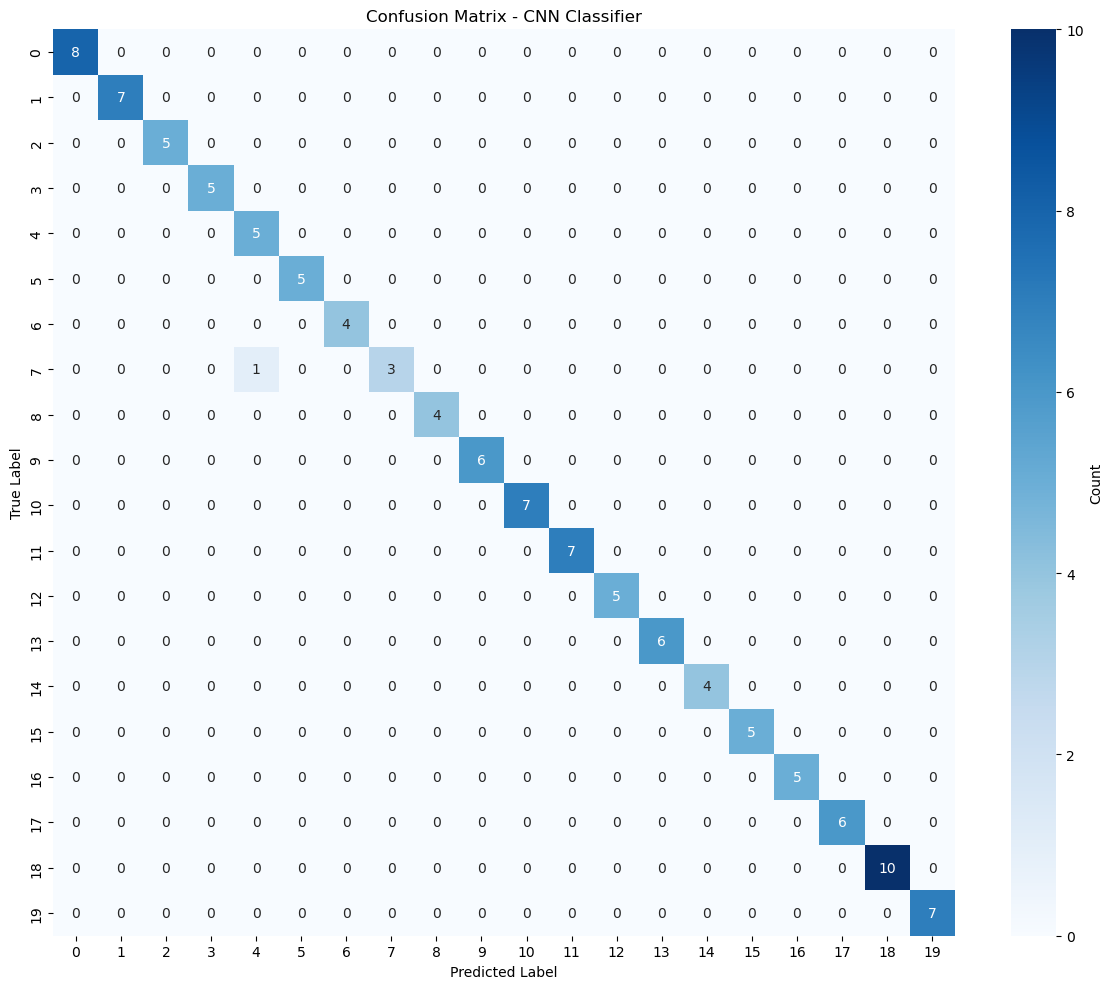

In [ ]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Classifier')
plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/05_cnn_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd

print("\n--- Classification Report ---")
report = classification_report(test_labels, test_preds, output_dict=True)
print(classification_report(test_labels, test_preds))

report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{DIRS['results']}/05_cnn_classification_report.csv")
print(f"\nClassification report saved to {DIRS['results']}/05_cnn_classification_report.csv")


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00       

In [ ]:
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})
history_df.to_csv(f"{DIRS['results']}/05_cnn_training_history.csv", index=False)

torch.save(model.state_dict(), f"{DIRS['models']}/cnn_final.pth")

summary = {
    'Model': 'CNN Classifier',
    'Epochs': len(train_losses),
    'Best Val Accuracy': max(val_accs),
    'Final Train Accuracy': train_accs[-1],
    'Final Val Accuracy': val_accs[-1],
    'Test Accuracy': test_accuracy / 100,  
    'Learning Rate': learning_rate,
    'Batch Size': batch_size
}
summary_df = pd.DataFrame([summary])
summary_df.to_csv(f"{DIRS['results']}/05_cnn_summary.csv", index=False)

print("\n--- Training Summary ---")
print(summary_df.to_string(index=False))
print(f"\nModels saved to {DIRS['models']}/")
print(f"Figures saved to {DIRS['figures']}/")
print(f"Results saved to {DIRS['results']}/")


--- Training Summary ---
         Model  Epochs  Best Val Accuracy  Final Train Accuracy  Final Val Accuracy  Test Accuracy  Learning Rate  Batch Size
CNN Classifier      30                1.0              0.991304                 1.0       0.991304         0.0005         128

✓ Models saved to ..\outputs\models/
✓ Figures saved to ..\outputs\figures/
✓ Results saved to ..\outputs\results/
